# Tanzania Water Well Modeling

In this project I work with the Tanzania Water Well data.

We are given the following prompt with this data set:

`Tanzania, as a developing country, struggles with providing clean water to its population of over 57,000,000. There are many water points already established in the country, but some are in need of repair while others have failed altogether.`

`Build a classifier to predict the condition of a water well, using information about the sort of pump, when it was installed, etc. Your audience could be an NGO focused on locating wells needing repair, or the Government of Tanzania looking to find patterns in non-functional wells to influence how new wells are built. Note that this is a ternary classification problem by default, but can be engineered to be binary.`

This notebook contains the modeling process for a Logistic Regression classifier model.

### Imports

In [1]:
import pandas as pd
import numpy as np
import math

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

from sklearn.preprocessing import OneHotEncoder, StandardScaler, PolynomialFeatures
from sklearn.impute import SimpleImputer

from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.feature_selection import SelectFromModel

from sklearn.metrics import plot_confusion_matrix, confusion_matrix, log_loss

from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImPipeline

### Load in Data

In [2]:
with open('../data/Tanzania_Training_Cleaned.csv') as f:
    df = pd.read_csv(f)
    
# Copy and paste column lists from Cleaning notebook
num_cols = ['amount_tsh', 'gps_height', 'longitude', 'latitude', 'population']
cat_cols = ['funder', 'installer', 'basin', 'subvillage', 'region', 'region_code', 
            'district_code', 'lga', 'ward', 'scheme_management', 'construction_year', 
            'extraction_type_group', 'management', 'payment_type', 'water_quality', 
            'quantity', 'source', 'waterpoint_type']
bin_cols = ['public_meeting', 'permit']

### Basic Understanding

In [3]:
df.shape

(59400, 26)

In [4]:
df.describe()

,amount_tsh,gps_height,longitude,latitude,region_code,district_code,population,construction_year,status_group
count,17761.000000,38962.000000,57588.000000,57588.000000,59400.000000,59400.000000,30994.000000,38691.000000,59400.000000
mean,1062.351942,1018.860839,35.149669,-5.885572,15.297003,5.629747,344.570820,1996.814686,0.688434
std,5409.344940,612.566092,2.607428,2.809876,17.587406,9.633649,607.731177,12.472045,0.599877
min,0.200000,-90.000000,29.607122,-11.649440,1.000000,0.000000,2.000000,1960.000000,0.000000
25%,50.000000,393.000000,33.285100,-8.643841,5.000000,2.000000,100.000000,1987.000000,0.000000
50%,250.000000,1167.000000,35.005943,-5.172704,12.000000,3.000000,200.000000,2000.000000,1.000000
75%,1000.000000,1498.000000,37.233712,-3.372824,17.000000,5.000000,380.000000,2008.000000,1.000000
max,350000.000000,2770.000000,40.345193,-0.998464,99.000000,80.000000,30500.000000,2013.000000,2.000000


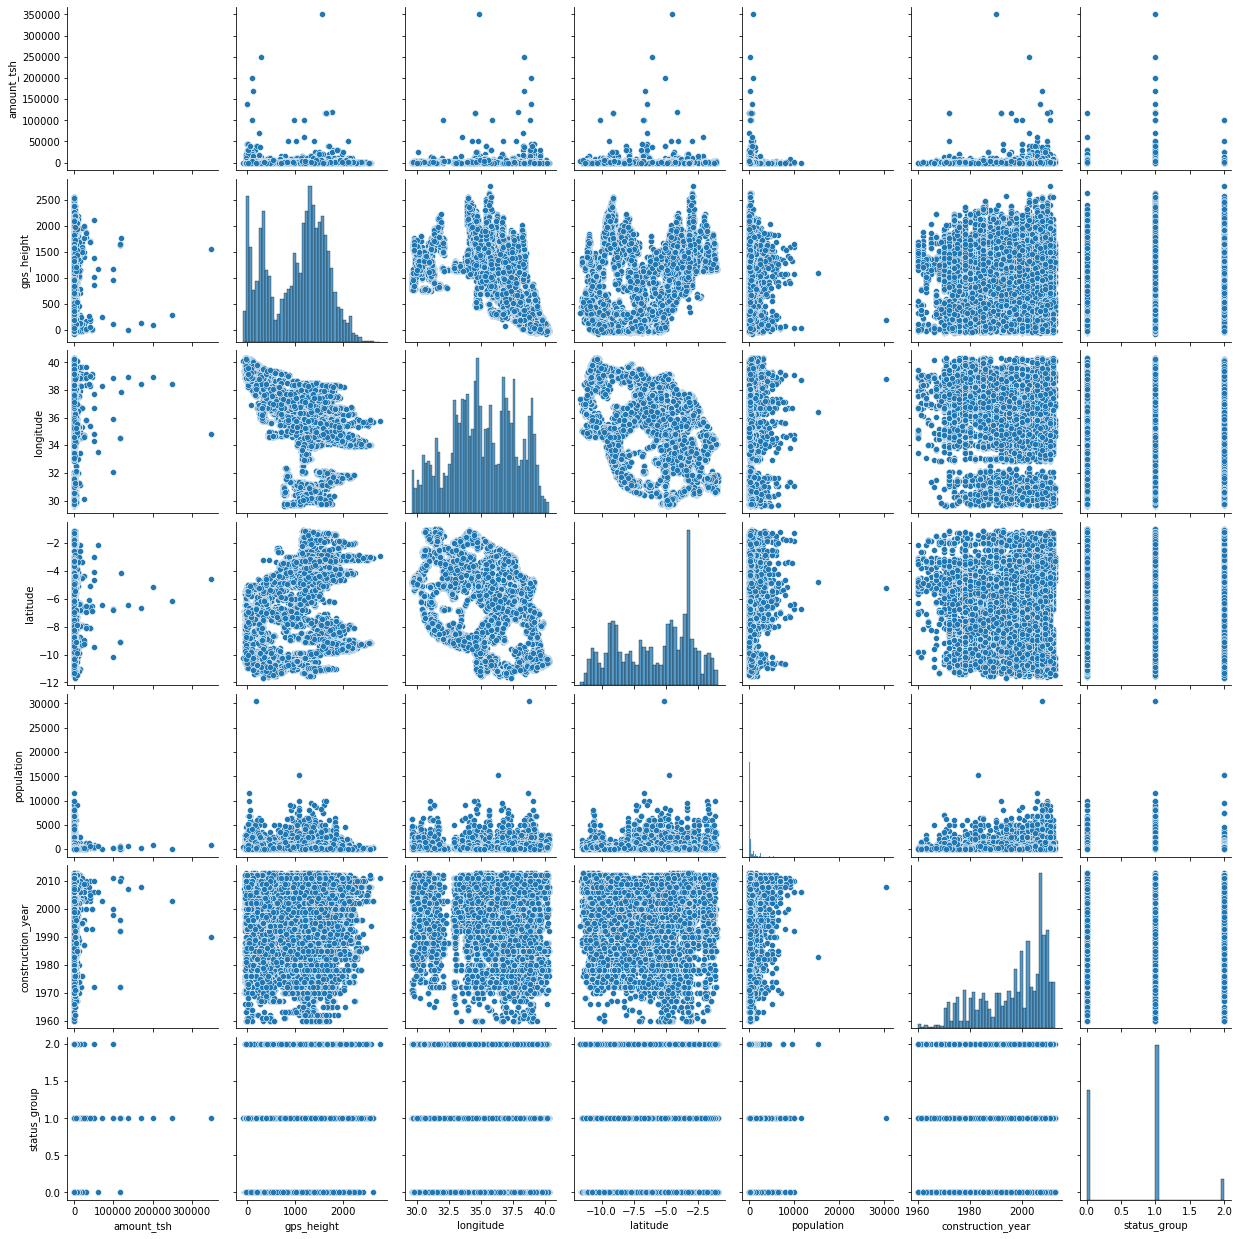

In [5]:
sns.pairplot(df[['amount_tsh', 'gps_height', 'longitude', 'latitude', 
                 'population', 'construction_year', 'status_group']]);

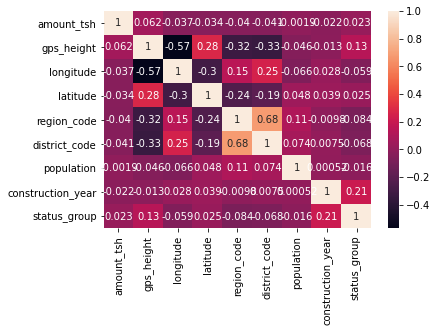

In [6]:
sns.heatmap(df.corr(), annot=True);

No major correlations to note.

### Train Test Split

In [7]:
X = df.drop('status_group', axis=1)
y = df.status_group
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

### Dummy Model

In [8]:
dummy_model = DummyClassifier(strategy='most_frequent').fit(X_train, y_train)

In [9]:
dummy_model.score(X_train, y_train)

0.542334455667789

In [10]:
y_train.value_counts(normalize=True)

1    0.542334
0    0.384871
2    0.072795
Name: status_group, dtype: float64

So, our dummy model is 54.2% accurate by simply predicting the most frequent class. That's the number to beat with our next model.

### Model Evaluation Class

Before going further, let's build a model evaluation function that we can use for each iteration. For this code, we start with the function `ModelWithCV()` used in lecture 41 and tweak it for our use.

In [96]:
class ModelEvaluation():
    
    def __init__(self, model, model_name, X, y):
        self.model = model
        self.name = model_name
        self.X_train, self.X_test, self.y_train, self.y_test = \
        train_test_split(X, y, random_state=42)
        
        # Attributes for cross validation
        self.cv_results = None
        self.cv_mean = None
        self.cv_std = None
        
        # Attributes for accuracy and loss summary
        self.training_accuracy = model.score(self.X_train, self.y_train)
        self.testing_accuracy = model.score(self.X_test, self.y_test)
        self.training_loss = log_loss(self.y_train, model.predict_proba(self.X_train)) 
        self.testing_loss = log_loss(self.y_test, model.predict_proba(self.X_test))
        
        # Attributes for confusion matrix summary
        self.functional_recall = None
        self.non_functional_recall = None
        self.needs_repair_recall = None
        
    # This is an accuracy and loss summary for both the train and test data
    def summary(self):
        eval_summary = (f'''
        Training accuracy: {self.training_accuracy:.2%}
        Training loss: {self.training_loss:.2f}
        Testing accuracy: {self.testing_accuracy:.2%}
        Testing loss: {self.testing_loss:.2f}
        ''')
        print(eval_summary)
        
    # Runs cross validation and prints summary
    def cross_validate(self, kfolds=5):
        cv_X = self.X_train
        cv_y = self.y_train

        self.cv_results = cross_val_score(self.model, cv_X, cv_y, cv=kfolds)
        self.cv_mean = np.mean(self.cv_results)
        self.cv_std = np.std(self.cv_results)
        
        cv_summary = (
        f'''CV Results for `{self.name}` model:
            {self.cv_mean:.5f} ± {self.cv_std:.5f} accuracy
        ''')
        print(cv_summary)

    # Plots confusion matrix for the train and test data
    def plot_cm(self):
        #fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 6))
        fig, ax = plt.subplots(figsize=(7, 7))
        
        fig.patch.set_facecolor('none')
        
        #axes[0].set_title(f'Training Confusion Matrix for `{self.name}` Model')
        #axes[1].set_title(f'Testing Confusion Matrix for `{self.name}` Model')
        ax.set_title(f'Confusion Matrix for `{self.name}` Model')
        
        #plot_confusion_matrix(self.model, self.X_train, self.y_train, ax=axes[0], cmap='plasma')
        #plot_confusion_matrix(self.model, self.X_test, self.y_test, ax=axes[1], cmap='PuBu');
        plot_confusion_matrix(self.model, self.X_test, self.y_test, ax=ax, cmap='PuBu')
        fig.savefig(f'../images/{self.name}_CM');
    
    # Summary of accuracy of class predictions for testing data
    def cm_summary(self):
        cm = confusion_matrix(self.y_test, self.model.predict(self.X_test))
        self.functional_recall = cm[1, 1] / (cm[1, 0] + cm[1, 1] + cm[1, 2])
        self.non_functional_recall = cm[0, 0] / (cm[0, 0] + cm[0, 1] + cm[0, 2])
        self.needs_repair_recall = cm[2, 2] / (cm[2, 0] + cm[2, 1] + cm[2, 2])
        
        cm_summary = (f'''
        Functional recall: {self.functional_recall:.2%} 
        Non-Functional recall: {self.non_functional_recall:.2%} 
        Needs Repair recall: {self.needs_repair_recall:.2%}
        ''')
        print(cm_summary)

Let's test this out on our Dummy Model.

In [97]:
dummy_eval = ModelEvaluation(
    model = dummy_model,
    model_name = 'Dummy',
    X = X,
    y = y
)

In [98]:
dummy_eval.summary()


        Training accuracy: 54.23%
        Training loss: 15.81
        Testing accuracy: 54.53%
        Testing loss: 15.70
        


In [99]:
dummy_eval.cross_validate()

CV Results for `Dummy` model:
            0.54233 ± 0.00004 accuracy
        


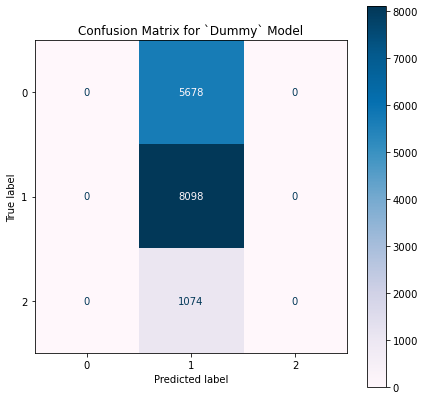

In [100]:
dummy_eval.plot_cm()

In [16]:
dummy_eval.cm_summary()


        Functional recall: 100.00% 
        Non-Functional recall: 0.00% 
        Needs Repair recall: 0.00%
        


Sweet! This will be very useful to get a sense of our models' relative performance.

### First Simple Model

Let's get some sub-pipelines going for our Numeric and Categorical features. We need to impute any nulls for both types. For this first model, we will scale our numerics and one hot encode our categoricals.

In [17]:
# Numeric columns sub-pipeline
num_sub_pipe = Pipeline(steps=[
    ('num_impute', SimpleImputer(strategy='mean', add_indicator=True)),
    ('ss', StandardScaler())
])

# Categorical columns sub-pipeline
cat_sub_pipe = Pipeline(steps=[
    ('cat_impute', SimpleImputer(strategy='most_frequent', add_indicator=True)),
    ('ohe', OneHotEncoder(sparse=True, handle_unknown='ignore'))
])

# Binary columns sub-pipeline
bin_sub_pipe = Pipeline(steps=[
    ('bin_impute', SimpleImputer(strategy='most_frequent', add_indicator=True))
])

# Column Transformer
ct = ColumnTransformer(transformers=[
    ('numerics', num_sub_pipe, num_cols),
    ('categoricals', cat_sub_pipe, cat_cols),
    ('binary', bin_sub_pipe, bin_cols)
])

In [18]:
# First Simple Model
fsm_pipe = Pipeline(steps=[
    ('ct', ct),
    ('fsm', LogisticRegression(multi_class='multinomial', n_jobs=-1))
])

In [19]:
fsm_pipe.fit(X_train, y_train)

Pipeline(steps=[('ct',
                 ColumnTransformer(transformers=[('numerics',
                                                  Pipeline(steps=[('num_impute',
                                                                   SimpleImputer(add_indicator=True)),
                                                                  ('ss',
                                                                   StandardScaler())]),
                                                  ['amount_tsh', 'gps_height',
                                                   'longitude', 'latitude',
                                                   'population']),
                                                 ('categoricals',
                                                  Pipeline(steps=[('cat_impute',
                                                                   SimpleImputer(add_indicator=True,
                                                                                 strategy='most_freq

In [20]:
fsm_eval = ModelEvaluation(
    model = fsm_pipe,
    model_name = 'Simple LogReg',
    X = X,
    y = y
)

In [21]:
fsm_eval.summary()


        Training accuracy: 76.68%
        Training loss: 0.57
        Testing accuracy: 75.88%
        Testing loss: 0.58
        


In [22]:
fsm_eval.cross_validate()

CV Results for `Simple LogReg` model:
            0.75865 ± 0.00445 accuracy
        


Wow! Big improvement over our baseline dummy model. And the loss isn't bad either.

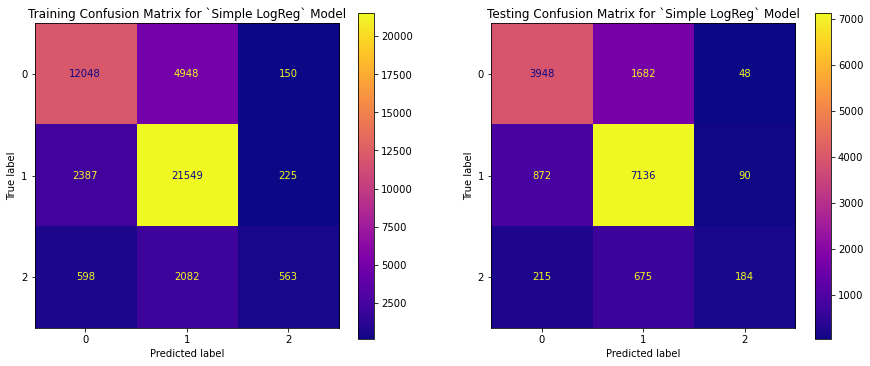

In [23]:
fsm_eval.plot_cm()

In [24]:
fsm_eval.cm_summary()


        Functional recall: 88.12% 
        Non-Functional recall: 69.53% 
        Needs Repair recall: 17.13%
        


We could definitely improve our recall for the non_functional and needs repair categories. Let's add a polynomial features transformer to the pipeline and see what happens.

### Adding in Polynomials

In [25]:
# New numerics sub-pipeline with polynomial features
poly_num_sub_pipe = Pipeline(steps=[
    ('num_impute', SimpleImputer(strategy='mean', add_indicator=True)),
    ('poly', PolynomialFeatures(degree=2)),
    ('ss', StandardScaler())
])

# New Column Transformer with our new poly_num_sub_pipe
poly_ct = ColumnTransformer(transformers=[
    ('poly_numerics', poly_num_sub_pipe, num_cols),
    ('categoricals', cat_sub_pipe, cat_cols),
    ('binary', bin_sub_pipe, bin_cols)
])

In [26]:
# First Polynomial Model
first_poly_pipe = Pipeline(steps=[
    ('ct', poly_ct),
    ('lr', LogisticRegression(multi_class='multinomial', n_jobs=-1))
])

In [27]:
first_poly_pipe.fit(X_train, y_train)

Pipeline(steps=[('ct',
                 ColumnTransformer(transformers=[('poly_numerics',
                                                  Pipeline(steps=[('num_impute',
                                                                   SimpleImputer(add_indicator=True)),
                                                                  ('poly',
                                                                   PolynomialFeatures()),
                                                                  ('ss',
                                                                   StandardScaler())]),
                                                  ['amount_tsh', 'gps_height',
                                                   'longitude', 'latitude',
                                                   'population']),
                                                 ('categoricals',
                                                  Pipeline(steps=[('cat_impute',
                               

In [28]:
poly_eval = ModelEvaluation(
    model = first_poly_pipe,
    model_name = 'Polynomial',
    X = X,
    y = y
)

In [29]:
poly_eval.summary()


        Training accuracy: 76.37%
        Training loss: 0.57
        Testing accuracy: 75.49%
        Testing loss: 0.58
        


In [30]:
poly_eval.cross_validate()

CV Results for `Polynomial` model:
            0.75809 ± 0.00278 accuracy
        


Darn, just slightly worse.

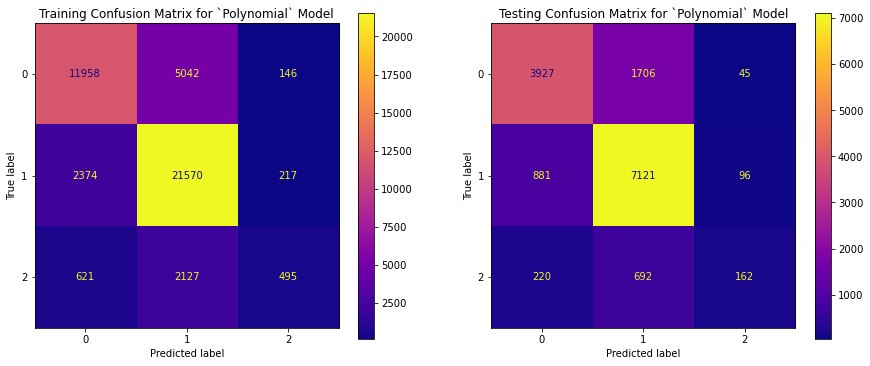

In [31]:
poly_eval.plot_cm()

In [32]:
poly_eval.cm_summary()


        Functional recall: 87.94% 
        Non-Functional recall: 69.16% 
        Needs Repair recall: 15.08%
        


A little worse recall for our minority classes, too. Let's try to oversample those and see if we can improve that. And skip the polynomial features, too.

### SMOTE?

In [33]:
smote_pipe = ImPipeline(steps=[
    ('ct', ct),
    ('sm', SMOTE(random_state=42)),
    ('lr', LogisticRegression(multi_class='multinomial', n_jobs=-1))
])

In [34]:
smote_pipe.fit(X_train, y_train)

Pipeline(steps=[('ct',
                 ColumnTransformer(transformers=[('numerics',
                                                  Pipeline(steps=[('num_impute',
                                                                   SimpleImputer(add_indicator=True)),
                                                                  ('ss',
                                                                   StandardScaler())]),
                                                  ['amount_tsh', 'gps_height',
                                                   'longitude', 'latitude',
                                                   'population']),
                                                 ('categoricals',
                                                  Pipeline(steps=[('cat_impute',
                                                                   SimpleImputer(add_indicator=True,
                                                                                 strategy='most_freq

In [101]:
smote_eval = ModelEvaluation(
    model = smote_pipe,
    model_name = 'SMOTE',
    X = X,
    y = y
)

In [102]:
smote_eval.summary()


        Training accuracy: 67.75%
        Training loss: 0.71
        Testing accuracy: 66.28%
        Testing loss: 0.74
        


In [73]:
smote_eval.cross_validate()

CV Results for `SMOTE` model:
            0.66676 ± 0.00509 accuracy
        


Accuracy down, loss slightly up. But what about our recall scores?

NameError: name 'fig' is not defined

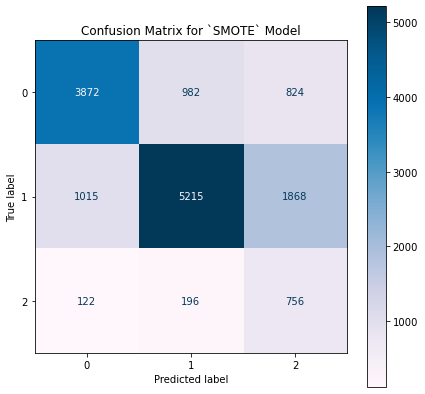

In [103]:
smote_eval.plot_cm()
fig.savefig('../images/SMOTE_CM')

In [75]:
smote_eval.cm_summary()


        Functional recall: 64.40% 
        Non-Functional recall: 68.19% 
        Needs Repair recall: 70.39%
        


Interesting. We were much less accurate at identifying the functional wells, but made significant improvement in the recall of wells that are functional but need repair. Non-functional wells are about the same. 

We might be okay with this trade-off. Faulty wells put lives at risk, and although we may spend money visiting more wells labeled faulty that are actually functional, we will also be able to fix a larger portion of the faulty wells.

In this case, however, since our non-functional recall is about the same (in fact, just slightly worse), we are going to opt for the non-Smote model.

### Grid Search

Let's do one last iteration and grid search on our simple Logistic Regression model.

In [40]:
pd.DataFrame.from_dict(fsm_pipe.get_params(), orient='index').index

Index(['memory', 'steps', 'verbose', 'ct', 'fsm', 'ct__n_jobs',
       'ct__remainder', 'ct__sparse_threshold', 'ct__transformer_weights',
       'ct__transformers', 'ct__verbose', 'ct__numerics', 'ct__categoricals',
       'ct__binary', 'ct__numerics__memory', 'ct__numerics__steps',
       'ct__numerics__verbose', 'ct__numerics__num_impute', 'ct__numerics__ss',
       'ct__numerics__num_impute__add_indicator',
       'ct__numerics__num_impute__copy',
       'ct__numerics__num_impute__fill_value',
       'ct__numerics__num_impute__missing_values',
       'ct__numerics__num_impute__strategy',
       'ct__numerics__num_impute__verbose', 'ct__numerics__ss__copy',
       'ct__numerics__ss__with_mean', 'ct__numerics__ss__with_std',
       'ct__categoricals__memory', 'ct__categoricals__steps',
       'ct__categoricals__verbose', 'ct__categoricals__cat_impute',
       'ct__categoricals__ohe', 'ct__categoricals__cat_impute__add_indicator',
       'ct__categoricals__cat_impute__copy',
       'c

In [41]:
params = {
    'ct__numerics__num_impute__strategy' : ['mean', 'median'],
    'fsm__solver' : ['newton-cg', 'sag', 'lbfgs'],
    'fsm__max_iter': [100, 1000, 10000],
    'fsm__C' : [1, 10, 100],
    'fsm__tol' : [0.0001, 0.001, 0.01]
}

In [42]:
gs = GridSearchCV(
    estimator = fsm_pipe,
    param_grid = params,
    cv=3,
    verbose=2,
    n_jobs=-1
)

In [43]:
gs.fit(X_train, y_train)

Fitting 3 folds for each of 162 candidates, totalling 486 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:   43.5s
[Parallel(n_jobs=-1)]: Done 138 tasks      | elapsed:  8.8min
[Parallel(n_jobs=-1)]: Done 341 tasks      | elapsed: 31.4min
[Parallel(n_jobs=-1)]: Done 486 out of 486 | elapsed: 54.8min finished


GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('ct',
                                        ColumnTransformer(transformers=[('numerics',
                                                                         Pipeline(steps=[('num_impute',
                                                                                          SimpleImputer(add_indicator=True)),
                                                                                         ('ss',
                                                                                          StandardScaler())]),
                                                                         ['amount_tsh',
                                                                          'gps_height',
                                                                          'longitude',
                                                                          'latitude',
                                                                

In [44]:
gs.best_params_

{'ct__numerics__num_impute__strategy': 'median',
 'fsm__C': 100,
 'fsm__max_iter': 1000,
 'fsm__solver': 'sag',
 'fsm__tol': 0.001}

In [45]:
gs_best = gs.best_estimator_

In [107]:
gs_eval = ModelEvaluation(
    model = gs_best,
    model_name = 'LogReg w/ Grid Search',
    X = X,
    y = y
)

In [108]:
gs_eval.summary()


        Training accuracy: 76.66%
        Training loss: 0.57
        Testing accuracy: 75.95%
        Testing loss: 0.58
        


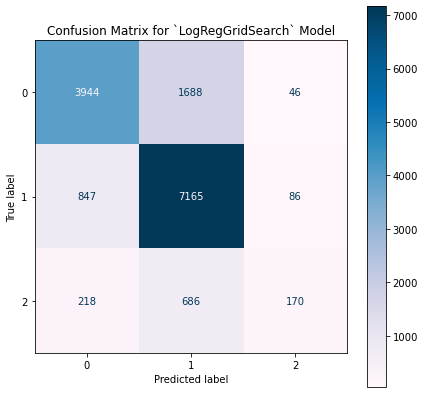

In [109]:
gs_eval.plot_cm()

In [49]:
gs_eval.cm_summary()


        Functional recall: 88.48% 
        Non-Functional recall: 69.46% 
        Needs Repair recall: 15.83%
        


### Model Comparison

In [50]:
model_scores = [dummy_eval, fsm_eval, poly_eval, smote_eval, gs_eval]

In [51]:
final_scores_dict = {
    "Model Name": [i.name for i in model_scores],
    "Training Accuracy": [i.training_accuracy for i in model_scores], 
    "Training Loss": [i.training_loss for i in model_scores], 
    "Testing Accuracy": [i.testing_accuracy for i in model_scores], 
    "Testing Loss": [i.testing_loss for i in model_scores], 
    "Functional Recall": [i.functional_recall for i in model_scores], 
    "Non-Functional Recall": [i.non_functional_recall for i in model_scores], 
    "Needs Repair Recall": [i.needs_repair_recall for i in model_scores]
}
final_scores_df = pd.DataFrame(final_scores_dict).set_index('Model Name')
final_scores_df

,Training Accuracy,Training Loss,Testing Accuracy,Testing Loss,Functional Recall,Non-Functional Recall,Needs Repair Recall
Model Name,,,,,,,
Dummy,0.542334,15.807208,0.545320,15.704096,1.000000,0.000000,0.000000
Simple LogReg,0.766779,0.567054,0.758788,0.583648,0.881205,0.695315,0.171322
Polynomial,0.763704,0.571156,0.754882,0.584802,0.879353,0.691617,0.150838
SMOTE,0.677486,0.713795,0.662828,0.739463,0.643986,0.681930,0.703911
LogReg w/ Grid Search,0.766644,0.568936,0.759529,0.583065,0.884786,0.694611,0.158287
